## **Predicting purchase probabilities**

### **Loading the data**

In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy

from tqdm import tqdm

tqdm.pandas()

In [2]:
DATA_PATH = '/Users/leonhagel/Documents/coding/github/mlim-g2/data/'
EXPORT_PATH = '/Users/leonhagel/Documents/coding/github/mlim-g2/export/'

In [3]:
class Helper:
    
    def __init__(self):
        self.data = {}
        self.mappings = {}
        
    def _load(self, filepath):
        import pandas as pd
        file_type = filepath.split('.')[1]
        
        if file_type == 'parquet':
            output = pd.read_parquet(filepath)
        
        return output

    
    # internal functions
    def __getitem__(self, item):
        return eval(f"self.{item}")
    
    
    def __setitem__(self, item, value):
        exec(f"self.{item} = value")
        
    
    def _format_time(self, seconds):
        return '{:02.0f}'.format(seconds//60)+':'+'{:02.0f}'.format(seconds%60)
    
    
    
    # loading from disk
    def load(self, files:dict):
        for attr, files in files.items():
            if type(files) == list:
                for file in files:
                    name = file.split('.')[0].split('/')[-1]
                    self[attr][name] = self._load(file)
            else:
                self[attr] = self.load(files)
    
    
    def _dump_data(self, export_path, name):
        self.data[name].to_parquet(f"{export_path}{name}.parquet")
    
    
    def dump(self, export_path, which='all'):
        if which == 'all':
            # data
            provided_data = ['baskets', 'coupon_index', 'coupons']
            data = [data for data in self.data.keys() if data not in provided_data]
            
            # mappings
            mappings = list(self.mappings.keys())
            
            # other attributes and objects
            other = []
            
            which = data + mappings + other
        
        if which == 'data':
            provided_data = ['baskets', 'coupon_index', 'coupons']
            which = [data for data in self.data.keys() if data not in provided_data]
        
        if which == 'mappings':
            which = list(self.mappings.keys())
        
        for name in which:
            if name in self.data.keys():
                self._dump_data(export_path, name)
            if name in self.mappings.keys():
                self._dump_data(export_path, name)
        
    # data preparation
    def get_merged(self, drop=False):
        similar = [x for x in self.data['coupons'].columns if x in self.data['baskets'].columns] # i.e. ['shopper', 'product', 'week'] 
        self.data['merged'] = self.data['baskets'].merge(self.data['coupons'], how='left', left_on=similar, right_on=similar)
        if drop:
            self.data.pop('baskets')
            self.data.pop('coupons')    

            
    def reduce_data_size(self, df):
        max_integer_values = {127: 'int8', 32767: 'int16', 2147483647: 'int32'}
        for column, dtype in df.dtypes.items():    
            if np.issubdtype(dtype, np.integer):
                # determining the minimum dtype
                max_value = np.max([abs(df[column].min()), df[column].max()])
                max_array = np.array(list(max_integer_values.keys()))
                max_idx = max_array[max_array > max_value][0]
                # converting integers
                df[column] = df[column].astype(max_integer_values[max_idx])
            # converting float
            if np.issubdtype(dtype, np.floating):
                df[column] = df[column].astype('float32')
        return df
    
    
    def reduce_shopper(self, df, shopper_range:tuple=(0,1999)):
        lower = df['shopper'] >= shopper_range[0]
        upper = df['shopper'] <= shopper_range[1]
        return df.loc[lower & upper]
    
    
    def clean(self, df='merged', shopper_range=(0,1999)):
        df = self.data['merged'].copy() if list(df) == list('merged') else df
        df = purchase.reduce_shopper(df, shopper_range)
    
        df['discount'].fillna(0, inplace=True)
        df['discount'] = df['discount'] / 100
    
        df['price'] = df['price'] / (1 - df['discount'])
        return df
    
    
    # data mappings
    def _init_df_map(self, rows, columns, initial_array=[]):
        rows = range(rows[0], rows[1]+1) if type(rows) == tuple else rows
        columns = range(columns[0], columns[1]+1) if type(columns) == tuple else columns

        rows = {row: deepcopy(initial_array) for row in rows}
        return pd.DataFrame({str(column): deepcopy(rows) for column in columns})
    
    
    def _get_mapping(self, df, row_name, column_name, value_name, rows='all', columns='all', initial_array=[]):
        rows = (df[row_name].min(), df[row_name].max())
        columns = (df[column_name].min(), df[column_name].max())
        mapping = self._init_df_map(rows=rows, columns=columns, initial_array=initial_array)
        df.progress_apply(lambda row: mapping.loc[int(row[row_name]), str(int(row[column_name]))].append(row[value_name]), axis = 1)
        return mapping
    
    
    def get_mappings(self, config:dict):
        for name, cnfg in config.items():
            self.mappings[name] = self._get_mapping(**cnfg)

    
    def aggregate_price_map(self, aggregation_function='mode', verbose=1):
        if aggregation_function == 'mode':
            import scipy.stats
            aggregation_function = lambda array: scipy.stats.mode(array)[0][0]
    
        price_map = pd.DataFrame()
        for column in tqdm(self.mappings['prices'].columns) if verbose >=1 else self.mappings['prices'].columns:
            price_map[column] = self.mappings['prices'][column].apply(aggregation_function)
    
        return price_map
    
    
    

In [4]:
class Purchase_Probabilities(Helper):
    
    def __init__(self):
        super().__init__()
        
    
    # creating purchase history features
    def get_history(self, shopper, product, week):
        arr = np.array(self.mappings['product_histories'].loc[shopper, str(product)])
        return arr[arr < week]

    
    def get_last_purchase(self, shopper, product, week):
        return self.get_history(shopper, product, week)[-1]

    
    def get_trend(self, shopper, product, week, trend_window): # i.e. purchase frequency over the specified trend window
        history = self.get_history(shopper, product, week)
        return np.unique(history[history >= week - trend_window]).shape[0] / trend_window


    def prepare(self, df='clean', shopper=(0,1999), week=(0,89), product=(0,249), price_aggregation_fn='mode'):
        import itertools
        import time
    
        start = time.time()
        if type(df) == str:
            df = self.data[df]

        shopper = range(shopper[0], shopper[-1]+1) if type(shopper) != list else shopper
        week = range(week[0], week[-1]+1) if type(week) != list else week
        product = range(product[0], product[-1]+1) if type(product) != list else product

        print(f"[prepare] itertools... (elapsed time: {self._format_time(time.time()-start)})")
        output = pd.DataFrame(itertools.product(shopper, week, product))
        output.rename(columns={0:'shopper', 1:'week', 2:'product'}, inplace=True)
        print(f"[prepare] merge... (elapsed time: {self._format_time(time.time()-start)})")
        if all([type(df) != pd.core.frame.DataFrame, df == None]):
            output['price'] = None
            output['discount'] = None
            output['purchased'] = None
        else:
            output = output.merge(df, how='left', left_on=list(output.columns), right_on=list(output.columns))
            output['purchased'] = output['price'].notna().astype(int) # target
            output['discount'].fillna(0, inplace=True)


        print(f"[prepare] cleaning... (elapsed time: {self._format_time(time.time()-start)})")
        price_map = self.aggregate_price_map(price_aggregation_fn, verbose = 0)
        output.loc[output['price'].isna(), 'price'] = output.loc[output['price'].isna(), :].progress_apply(lambda row: price_map.loc[row['week'], str(int(row['product']))], axis=1)

        print(f"[prepare] feature creation... (elapsed time: {self._format_time(time.time()-start)})")
        # last purchase
        output['weeks_since_last_purchase'] = output.progress_apply(lambda row: self.get_last_purchase(int(row['shopper']), str(int(row['product'])), row['week']), axis=1)
        output['weeks_since_last_purchase'] = output['week'] - output['weeks_since_last_purchase']
        output.loc[output['weeks_since_last_purchase'] == np.inf, 'weeks_since_last_purchase'] = np.ceil(output['week'].max() * 1.15)
        # trends
        trend_windows = [1, 3, 5]
        for window in trend_windows:
            output['trend_'+str(window)] = output.progress_apply(lambda row: self.get_trend(int(row['shopper']), str(int(row['product'])), row['week'], window), axis=1)
        output['product_freq'] = output.progress_apply(lambda row: self.get_trend(int(row['shopper']), str(int(row['product'])), row['week'], row['week']), axis=1)

        print(f"[prepare] done (elapsed time: {self._format_time(time.time()-start)})")
        self.data['purchase'] = output
        
        
    def train_test_split(self, test_week, train_window, features='default'):
        import category_encoders as ce
        from IPython.display import clear_output
    
        df = self.data['purchase']
        start = test_week - train_window
    
        train = df.loc[(df['week'] >= start) & (df['week'] < test_week), :]
        test = df.loc[(df['week'] == test_week), :]
    
        # WOE category encoding
        encoder = ce.WOEEncoder()
        train.loc[:,'shopper_WOE'] = encoder.fit_transform(train['shopper'].astype('category'), train['purchased'])['shopper'].values
        test.loc[:,'shopper_WOE'] = encoder.transform(test['shopper'].astype('category'))['shopper'].values
        encoder = ce.WOEEncoder()
        train.loc[:,'product_WOE'] = encoder.fit_transform(train['product'].astype('category'), train['purchased'])['product'].values
        test.loc[:,'product_WOE'] = encoder.transform(test['product'].astype('category'))['product'].values
        clear_output()
    
        # final split
        features = [col for col in train.columns if col not in ['purchased', 'shopper', 'week', 'product', 'product_history', 'last_purchase']] if features == 'default' else features
        X_train = train.loc[:, features]
        y_train = train['purchased']
        X_test = test.loc[:, features]
        y_test = test['purchased']
    
        return X_train, y_train, X_test, y_test
    
    
    def predict(self, model, X):
        import lightgbm
        if type(model) == lightgbm.sklearn.LGBMClassifier:
            y_hat = model.predict_proba(X)[:, 1]
        return 
    
    
    def score(self, y_true, y_hat, metric='log_loss'):
        if metric == 'log_loss':
            import sklearn
            metric = sklearn.metrics.log_loss
    
        return metric(y_true, y_hat)

In [5]:
files = {
    'data': [
        DATA_PATH + 'baskets.parquet',
        DATA_PATH + 'coupon_index.parquet', 
        DATA_PATH + 'coupons.parquet', 
        DATA_PATH + 'merged.parquet'
    ], 
    'mappings': [
        EXPORT_PATH + 'product_histories.parquet',
        EXPORT_PATH + 'prices.parquet',
    ]
}

In [6]:
purchase = Purchase_Probabilities()
purchase.load(files)

# reduce file sizes
for name, df in purchase.data.items():
    purchase.data[name] = purchase.reduce_data_size(purchase.data[name])
    
# clean the data
purchase.data['clean'] = purchase.clean()

In [7]:
# preparing the data
df = 'clean' #None
shopper = (0, 1999)
week = (0, 89)
product = (0, 249)
price_aggregation_fn = 'mode'

purchase.prepare(df, shopper, week, product, price_aggregation_fn)
purchase.dump(DATA_PATH, which='data')
purchase.data['purchase']

[prepare] itertools... (elapsed time: 00:00)
[prepare] merge... (elapsed time: 00:60)
[prepare] cleaning... (elapsed time: 01:22)


  0%|          | 0/45000000 [00:00<?, ?it/s]

[prepare] feature creation... (elapsed time: 46:54)


  0%|          | 1/45000000 [00:09<118920:29:15,  9.51s/it]<ipython-input-4-da9efe8667ea>:19: RuntimeWarning: invalid value encountered in double_scalars
  return np.unique(history[history >= week - trend_window]).shape[0] / trend_window
100%|██████████| 45000000/45000000 [53:49<00:00, 13935.28it/s] 


[prepare] done (elapsed time: 290:15)


,shopper,week,product,price,discount,purchased,weeks_since_last_purchase,trend_1,trend_3,trend_5,product_freq
0,0,0,0,688.0,0.0,0,103.0,0.0,0.0,0.0,NaN
1,0,0,1,560.0,0.0,0,103.0,0.0,0.0,0.0,NaN
2,0,0,2,773.0,0.0,0,103.0,0.0,0.0,0.0,NaN
3,0,0,3,722.0,0.0,0,103.0,0.0,0.0,0.0,NaN
4,0,0,4,620.0,0.0,0,103.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
44999995,1999,89,245,549.0,0.0,1,19.0,0.0,0.0,0.0,0.123596
44999996,1999,89,246,702.0,0.0,0,103.0,0.0,0.0,0.0,0.000000
44999997,1999,89,247,670.0,0.0,0,103.0,0.0,0.0,0.0,0.000000
44999998,1999,89,248,490.0,0.0,0,103.0,0.0,0.0,0.0,0.000000


### **EDA of raw data**

In [44]:
purchase.data['merged'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68841598 entries, 0 to 68841597
Data columns (total 5 columns):
 #   Column    Dtype  
---  ------    -----  
 0   week      int8   
 1   shopper   int32  
 2   product   int16  
 3   price     int16  
 4   discount  float32
dtypes: float32(1), int16(2), int32(1), int8(1)
memory usage: 1.3 GB


In [45]:
purchase.data['merged'].describe().round(2)

,week,shopper,product,price,discount
count,68841598.00,68841598.00,68841598.00,68841598.00,2708043.00
mean,44.50,50006.96,124.96,584.90,27.29
std,25.98,28881.66,69.84,97.75,9.78
min,0.00,0.00,0.00,234.00,10.00
25%,22.00,24981.00,66.00,506.00,20.00
50%,44.00,50019.00,123.00,579.00,30.00
75%,67.00,75041.00,189.00,654.00,35.00
max,89.00,99999.00,249.00,837.00,40.00


In [46]:
print('missing values:')
purchase.data['merged'].isna().sum()

missing values:


week               0
shopper            0
product            0
price              0
discount    66133555
dtype: int64

In [47]:
purchase.data['coupon_index']

,week,shopper,coupon
0,90,0,0
2000,90,0,1
4000,90,0,2
6000,90,0,3
8000,90,0,4
...,...,...,...
1999,90,1999,0
3999,90,1999,1
5999,90,1999,2
7999,90,1999,3


In [48]:
applied_discounts = purchase.data['merged']['discount'].astype('category').unique()
applied_discounts

/Users/leonhagel/env/mlim-g2/lib/python3.8/site-packages/pandas/io/formats/format.py:1405: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


[NaN, 35.0, 10.0, 25.0, 30.0, 20.0, 15.0, 40.0]
Categories (7, float64): [35.0, 10.0, 25.0, 30.0, 20.0, 15.0, 40.0]

<br>

## **Data preparation**

### **Data cleaning**

**Final function**

In [49]:
# final function
def clean(self, df='merged', shopper_range=(0,1999)):
    df = self.data['merged'].copy() if list(df) == list('merged') else df
    df = purchase.reduce_shopper(df, shopper_range)
    
    df['discount'].fillna(0, inplace=True)
    df['discount'] = df['discount'] / 100
    
    df['price'] = df['price'] / (1 - df['discount'])
    return df

del clean

<br>

**Copy data**

In [50]:
df = purchase.data['merged'].copy()
df

,week,shopper,product,price,discount
0,0,0,71,629,NaN
1,0,0,91,605,NaN
2,0,0,116,715,NaN
3,0,0,123,483,NaN
4,0,0,157,592,NaN
...,...,...,...,...,...
68841593,89,99999,143,470,NaN
68841594,89,99999,158,566,NaN
68841595,89,99999,186,499,NaN
68841596,89,99999,204,496,NaN


<br>

**Reducing shoppers**

In [51]:
df = purchase.reduce_shopper(df)
df

,week,shopper,product,price,discount
0,0,0,71,629,NaN
1,0,0,91,605,NaN
2,0,0,116,715,NaN
3,0,0,123,483,NaN
4,0,0,157,592,NaN
...,...,...,...,...,...
68091869,89,1999,144,562,NaN
68091870,89,1999,158,566,NaN
68091871,89,1999,192,549,NaN
68091872,89,1999,213,592,NaN


<br>

**Missing values: Discount**

In [55]:
df['discount'].fillna(0, inplace=True)
df['discount'] = df['discount'] / 100

applied_discounts = df['discount'].astype('category').unique()
print(applied_discounts)

df.describe().round(2)

/Users/leonhagel/env/mlim-g2/lib/python3.8/site-packages/pandas/core/series.py:4433: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
<ipython-input-55-03e92c5954db>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['discount'] = df['discount'] / 100
/Users/leonhagel/env/mlim-g2/lib/python3.8/site-packages/pandas/io/formats/format.py:1405: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


[0.000000, 0.000035, 0.000010, 0.000025, 0.000030, 0.000020, 0.000015, 0.000040]
Categories (8, float64): [0.000000, 0.000035, 0.000010, 0.000025, 0.000030, 0.000020, 0.000015, 0.000040]


,week,shopper,product,price,discount,price_discounted
count,1378720.00,1378720.00,1378720.00,1378720.00,1378720.0,1378720.00
mean,44.48,997.21,125.07,590.73,0.0,584.34
std,25.98,576.25,69.70,92.70,0.0,97.43
min,0.00,0.00,0.00,389.23,0.0,234.00
25%,22.00,499.00,66.00,510.00,0.0,506.00
50%,44.00,993.00,123.00,582.00,0.0,579.00
75%,67.00,1496.00,189.00,657.00,0.0,654.00
max,89.00,1999.00,249.00,837.65,0.0,837.00


**Calculating the price without discount**

In [53]:
df['price_discounted'] = df['price'].copy()
df['price'] = df['price'] / (1 - df['discount'])
assert any(df['price'] != df['price_discounted'])
df.describe().round(2)

<ipython-input-53-a2122add2da9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_discounted'] = df['price'].copy()
<ipython-input-53-a2122add2da9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price'] = df['price'] / (1 - df['discount'])


,week,shopper,product,price,discount,price_discounted
count,1378720.00,1378720.00,1378720.00,1378720.00,1378720.00,1378720.00
mean,44.48,997.21,125.07,590.73,0.01,584.34
std,25.98,576.25,69.70,92.70,0.06,97.43
min,0.00,0.00,0.00,389.23,0.00,234.00
25%,22.00,499.00,66.00,510.00,0.00,506.00
50%,44.00,993.00,123.00,582.00,0.00,579.00
75%,67.00,1496.00,189.00,657.00,0.00,654.00
max,89.00,1999.00,249.00,837.65,0.40,837.00


In [56]:
purchase.data['clean'] = purchase.clean()
purchase.data['clean'].describe().round(2)

,week,shopper,product,price,discount
count,1378720.00,1378720.00,1378720.00,1378720.00,1378720.00
mean,44.48,997.21,125.07,590.73,0.01
std,25.98,576.25,69.70,92.70,0.06
min,0.00,0.00,0.00,389.23,0.00
25%,22.00,499.00,66.00,510.00,0.00
50%,44.00,993.00,123.00,582.00,0.00
75%,67.00,1496.00,189.00,657.00,0.00
max,89.00,1999.00,249.00,837.65,0.40


<br>

### **Mappings**

**Loading clean data**

In [79]:
purchase.data['clean'] = purchase.clean()
df = purchase.data['clean']
df.describe().round(2)

,week,shopper,product,price,discount
count,1378720.00,1378720.00,1378720.00,1378720.00,1378720.00
mean,44.48,997.21,125.07,590.73,0.01
std,25.98,576.25,69.70,92.70,0.06
min,0.00,0.00,0.00,389.23,0.00
25%,22.00,499.00,66.00,510.00,0.00
50%,44.00,993.00,123.00,582.00,0.00
75%,67.00,1496.00,189.00,657.00,0.00
max,89.00,1999.00,249.00,837.65,0.40


**init map**

In [80]:
weeks = (df['week'].min(), df['week'].max())
products = (df['product'].min(), df['product'].max())

mapping = purchase._init_df_map(rows=weeks, columns=products, initial_array=[])
mapping


,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
1,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
2,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
3,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
4,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
86,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
87,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
88,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]


In [85]:
def _get_mapping(self, df, row_name, column_name, value_name, rows='all', columns='all', initial_array=[]):
    rows = (df[row_name].min(), df[row_name].max())
    columns = (df[column_name].min(), df[column_name].max())
    mapping = self._init_df_map(rows=rows, columns=columns, initial_array=initial_array)
    df.progress_apply(lambda row: mapping.loc[int(row[row_name]), str(int(row[column_name]))].append(row[value_name]), axis = 1)
    return mapping

setattr(Helper, '_get_mapping', _get_mapping)
del _get_mapping

In [86]:
def get_mappings(self, config:dict):
    for name, cnfg in config.items():
        self.mappings[name] = self._get_mapping(**cnfg)
        
setattr(Helper, 'get_mappings', get_mappings)
del get_mappings

**Price map and product histories**

In [408]:
df_full = purchase.data['merged'].copy()
df_full = purchase.clean(df_full, shopper_range=(0, df_full['shopper'].max())).loc[:, ['week', 'product', 'price', 'discount']]
df_full.describe().round(2)

,week,product,price,discount
count,68841598.00,68841598.00,68841598.00,68841598.00
mean,44.50,124.96,591.31,0.01
std,25.98,69.84,93.04,0.06
min,0.00,0.00,389.23,0.00
25%,22.00,66.00,510.00,0.00
50%,44.00,123.00,582.00,0.00
75%,67.00,189.00,657.00,0.00
max,89.00,249.00,837.65,0.40


In [83]:
df = purchase.data['clean'].copy()
df.describe().round(2)

,week,shopper,product,price,discount
count,1378720.00,1378720.00,1378720.00,1378720.00,1378720.00
mean,44.48,997.21,125.07,590.73,0.01
std,25.98,576.25,69.70,92.70,0.06
min,0.00,0.00,0.00,389.23,0.00
25%,22.00,499.00,66.00,510.00,0.00
50%,44.00,993.00,123.00,582.00,0.00
75%,67.00,1496.00,189.00,657.00,0.00
max,89.00,1999.00,249.00,837.65,0.40


In [411]:
map_config = {
    'product_histories': {'df': df, 'row_name': 'shopper', 'column_name': 'product', 'value_name': 'week', 'initial_array': [-np.inf]},
    'prices': {'df': df_full, 'row_name': 'week', 'column_name': 'product', 'value_name': 'price', 'initial_array': []}
    #'prices': {'df': df, 'row_name': 'week', 'column_name': 'product', 'value_name': 'price', 'initial_array': []}
}

purchase.get_mappings(map_config)

100%|██████████| 68841598/68841598 [35:36<00:00, 32219.81it/s]  


In [415]:

for name, df in purchase.mappings.items():
    df.to_parquet(f"{EXPORT_PATH}{name}.parquet")

In [88]:
purchase.mappings['product_histories'].head()

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,[-inf],[-inf],[-inf],[-inf],"[-inf, 24.0, 40.0, 45.0, 51.0, 54.0, 58.0, 60....",[-inf],[-inf],[-inf],[-inf],[-inf],...,"[-inf, 27.0]",[-inf],[-inf],"[-inf, 44.0]","[-inf, 5.0, 8.0, 20.0, 37.0, 38.0, 56.0, 59.0]",[-inf],[-inf],[-inf],[-inf],"[-inf, 10.0, 26.0, 28.0, 32.0, 35.0, 40.0, 65...."
1,"[-inf, 7.0, 11.0, 48.0, 61.0, 66.0, 81.0]","[-inf, 2.0, 6.0, 18.0, 20.0, 27.0, 29.0, 49.0,...",[-inf],[-inf],"[-inf, 5.0, 13.0, 21.0, 23.0, 30.0, 47.0, 69.0...",[-inf],[-inf],[-inf],[-inf],[-inf],...,[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],"[-inf, 4.0, 19.0, 22.0, 35.0, 79.0, 88.0]"
2,[-inf],"[-inf, 2.0, 3.0, 6.0, 7.0, 8.0, 9.0, 11.0, 13....",[-inf],[-inf],[-inf],[-inf],"[-inf, 5.0, 10.0, 15.0, 32.0, 54.0]",[-inf],[-inf],"[-inf, 1.0, 17.0]",...,"[-inf, 4.0, 5.0, 16.0, 18.0, 21.0, 26.0, 33.0,...",[-inf],[-inf],[-inf],[-inf],"[-inf, 75.0]",[-inf],[-inf],"[-inf, 3.0, 14.0, 20.0, 42.0, 45.0, 50.0, 51.0...","[-inf, 0.0, 23.0, 30.0, 31.0, 39.0]"
3,[-inf],[-inf],[-inf],[-inf],"[-inf, 7.0, 19.0, 27.0]",[-inf],"[-inf, 0.0, 13.0, 16.0, 18.0, 20.0, 23.0, 30.0...","[-inf, 11.0, 29.0, 38.0, 47.0, 69.0, 85.0]",[-inf],[-inf],...,[-inf],[-inf],[-inf],"[-inf, 57.0]",[-inf],"[-inf, 14.0, 87.0]",[-inf],[-inf],"[-inf, 2.0, 5.0, 10.0, 23.0, 38.0, 44.0, 47.0,...","[-inf, 16.0, 51.0, 71.0]"
4,[-inf],[-inf],"[-inf, 6.0, 15.0, 21.0, 22.0, 27.0, 28.0, 58.0...",[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],...,[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf]


In [58]:
purchase.mappings['prices'].head()

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,"[688.0, 688.0, 688.0, 688.0, 688.0, 688.0, 688...","[560.0, 560.0, 560.0, 560.0, 560.0, 560.0, 560...","[773.0, 773.0, 773.0, 773.0, 773.0, 773.0, 773...","[722.0, 722.0, 721.3333, 722.0, 722.0, 722.0, ...","[620.0, 620.0, 620.0, 620.0, 620.0, 620.0, 620...","[721.0, 721.0, 721.0, 721.0, 721.0, 721.0, 721...","[568.0, 568.0, 568.0, 568.0, 568.0, 568.0, 568...","[772.0, 772.0, 772.0, 772.0, 772.0, 772.0, 772...","[669.0, 669.0, 669.0, 669.0, 669.0, 669.0, 669...","[759.0, 759.0, 759.0, 759.0, 759.0, 759.0, 759...",...,"[528.0, 528.0, 528.0, 528.0, 528.0, 528.0, 528...","[699.0, 699.0, 699.0, 699.0, 699.0, 698.46155,...","[511.0, 511.0, 511.0, 511.0, 511.0, 511.0, 511...","[490.0, 490.0, 490.0, 490.0, 490.0, 490.0, 490...","[694.0, 694.0, 694.0, 694.0, 694.0, 694.0, 694...","[548.75, 549.0, 549.0, 549.0, 549.0, 549.0, 54...","[702.0, 702.0, 702.0, 702.0, 702.0, 702.0, 702...","[670.0, 670.0, 670.0, 670.0, 670.0, 670.0, 670...","[490.0, 490.0, 490.0, 490.0, 490.0, 490.0, 490...","[499.0, 499.0, 499.0, 499.0, 499.0, 499.0, 499..."
1,"[688.0, 688.0, 688.0, 688.0, 688.0, 688.0, 688...","[560.0, 560.0, 560.0, 560.0, 560.0, 560.0, 560...","[773.8462, 773.0, 773.0, 773.0, 773.0, 773.0, ...","[722.0, 722.0, 722.0, 722.0, 722.0, 722.0, 722...","[620.0, 620.0, 620.0, 620.0, 620.0, 620.0, 620...","[721.0, 721.0, 721.0, 721.0, 721.6666, 721.0, ...","[568.0, 568.0, 568.0, 568.0, 568.0, 568.0, 568...","[772.0, 772.0, 772.0, 772.0, 772.0, 772.0, 772...","[669.0, 669.0, 667.6923, 669.0, 669.0, 669.0, ...","[759.0, 759.0, 759.0, 759.0, 759.0, 759.0, 759...",...,"[528.0, 528.0, 528.0, 528.0, 528.0, 528.0, 528...","[699.0, 699.0, 699.0, 699.0, 699.0, 699.0, 699...","[511.0, 511.0, 511.0, 511.0, 511.0, 511.0, 511...","[490.0, 490.0, 490.0, 490.0, 490.0, 490.0, 490...","[694.0, 694.0, 694.0, 694.0, 694.0, 694.0, 694...","[549.0, 549.0, 549.0, 549.0, 549.0, 549.0, 549...","[702.0, 702.0, 702.0, 702.0, 702.0, 702.0, 702...","[670.0, 670.0, 670.0, 670.0, 670.0, 670.0, 670...","[490.0, 490.0, 490.0, 490.0, 490.0, 490.0, 490...","[499.0, 499.0, 499.0, 499.0, 499.0, 499.0, 499..."
2,"[688.0, 688.0, 688.0, 688.0, 688.0, 688.0, 688...","[560.0, 560.0, 560.0, 560.0, 560.0, 560.0, 560...","[773.0, 773.0, 773.0, 773.0, 773.0, 772.8572, ...","[722.0, 722.0, 722.0, 722.0, 722.0, 722.0, 722...","[620.0, 620.0, 620.0, 620.0, 620.0, 620.0, 620...","[721.0, 721.4286, 721.0, 721.0, 721.0, 721.0, ...","[568.0, 568.0, 568.0, 568.0, 568.0, 568.0, 568...","[772.0, 772.30774, 772.0, 772.0, 772.0, 772.0,...","[668.5714, 669.0, 669.0, 669.0, 669.0, 669.0, ...","[759.0, 759.0, 758.6667, 759.0, 759.0, 759.0, ...",...,"[528.0, 528.0, 528.0, 528.0, 527.1429, 528.0, ...","[699.0, 699.0, 699.0, 699.0, 699.0, 699.0, 699...","[511.0, 511.0, 511.0, 511.0, 511.0, 511.0, 511...","[490.0, 490.0, 490.0, 490.0, 490.0, 490.0, 490...","[694.0, 694.0, 694.0, 694.0, 694.0, 694.0, 694...","[549.0, 549.0, 549.0, 549.0, 549.0, 549.0, 549...","[702.0, 702.0, 702.0, 702.0, 702.0, 702.0, 702...","[670.0, 670.0, 670.0, 670.0, 670.0, 670.0, 670...","[490.0, 489.99997, 490.0, 490.0, 490.0, 490.0,...","[499.0, 499.0, 498.57144, 498.88892, 499.0, 49..."
3,"[688.0, 688.0, 688.0, 688.0, 688.0, 687.6923, ...","[560.0, 560.0, 560.0, 560.0, 560.0, 560.0, 560...","[773.0, 773.0, 773.0, 773.0, 773.0, 773.0, 773...","[722.0, 722.0, 722.0, 722.0, 722.2222, 722.0, ...","[620.0, 620.0, 620.0, 620.0, 620.0, 620.0, 620...","[721.0, 721.0, 721.0, 721.0, 721.0, 721.0, 721...","[568.0, 568.0, 568.0, 568.0, 568.0, 568.0, 568...","[772.0, 772.0, 772.0, 771.7647, 772.0, 772.0, ...","[669.0, 669.0, 669.0, 669.0, 669.0, 669.0, 669...","[759.0, 759.0, 759.0, 759.0, 759.0, 759.0, 759...",...,"[528.0, 527.7778, 528.0, 528.2353, 528.0, 528....","[699.0, 699.0, 699.0, 699.0, 699.0, 699.0, 699...","[511.0, 511.0, 511.0, 511.0, 511.0, 511.0, 511...","[490.0, 490.0, 490.0, 490.0, 490.0, 490.0, 490...","[694.0, 694.0, 694.0, 694.0, 694.0, 694.0, 694...","[549.0, 54

<br>

**Price map**

In [124]:
def aggregate_price_map(self, aggregation_function='mode', verbose=1):
    if aggregation_function == 'mode':
        import scipy.stats
        aggregation_function = lambda array: scipy.stats.mode(array)[0][0]
    
    price_map = pd.DataFrame()
    for column in tqdm(self.mappings['prices'].columns) if verbose >=1 else self.mappings['prices'].columns:
        price_map[column] = self.mappings['prices'][column].apply(aggregation_function)
    
    return price_map

setattr(Helper, 'aggregate_price_map', aggregate_price_map)
del aggregate_price_map

In [130]:
#aggregation_function = np.mean
purchase.aggregate_price_map()

100%|██████████| 250/250 [00:05<00:00, 49.93it/s]


,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,688.0,560.0,773.0,722.0,620.0,721.0,568.0,772.0,669.0,759.0,...,528.0,699.0,511.0,490.0,694.0,549.0,702.0,670.0,490.0,499.0
1,688.0,560.0,773.0,722.0,620.0,721.0,568.0,772.0,669.0,759.0,...,528.0,699.0,511.0,490.0,694.0,549.0,702.0,670.0,490.0,499.0
2,688.0,560.0,773.0,722.0,620.0,721.0,568.0,772.0,669.0,759.0,...,528.0,699.0,511.0,490.0,694.0,549.0,702.0,670.0,490.0,499.0
3,688.0,560.0,773.0,722.0,620.0,721.0,568.0,772.0,669.0,759.0,...,528.0,699.0,511.0,490.0,694.0,549.0,702.0,670.0,490.0,499.0
4,688.0,560.0,773.0,722.0,620.0,721.0,568.0,772.0,669.0,759.0,...,528.0,699.0,511.0,490.0,694.0,549.0,702.0,670.0,490.0,499.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,688.0,560.0,773.0,722.0,620.0,721.0,568.0,772.0,669.0,759.0,...,528.0,699.0,511.0,490.0,694.0,549.0,702.0,670.0,490.0,499.0
86,688.0,560.0,773.0,722.0,620.0,721.0,568.0,772.0,669.0,759.0,...,528.0,699.0,511.0,490.0,694.0,549.0,702.0,670.0,490.0,499.0
87,688.0,560.0,773.0,722.0,620.0,721.0,568.0,772.0,669.0,759.0,...,528.0,699.0,511.0,490.0,694.0,549.0,702.0,670.0,490.0,499.0
88,688.0,560.0,773.0,722.0,620.0,721.0,568.0,772.0,669.0,759.0,...,528.0,699.0,511.0,490.0,694.0,549.0,702.0,670.0,490.0,499.0


<br>

**Purchase history and trend features**

In [171]:
def get_history(self, shopper, product, week):
    arr = np.array(self.mappings['product_histories'].loc[shopper, str(product)])
    return arr[arr < week]

def get_last_purchase(self, shopper, product, week):
    return self.get_history(shopper, product, week)[-1]

def get_trend(self, shopper, product, week, trend_window): # i.e. purchase frequency over the specified trend window
    history = self.get_history(shopper, product, week)
    return np.unique(history[history >= week - trend_window]).shape[0] / trend_window


setattr(Purchase_Probabilities, 'get_history', get_history)
del get_history

setattr(Purchase_Probabilities, 'get_last_purchase', get_last_purchase)
del get_last_purchase

setattr(Purchase_Probabilities, 'get_trend', get_trend)
del get_trend

In [91]:
purchase.get_history(1999,4,50)

array([-inf,   0.,   4.,   8.,  12.,  14.,  20.,  28.,  30.,  41.,  42.,
        43.,  48.])

In [92]:
purchase.get_last_purchase(1999,4,50)

48

In [181]:
purchase.get_trend(1999,4,50, 10)

0.4

<br>

### **Data structure**

In [14]:
purchase.data['clean'] = purchase.clean()
df = purchase.data['clean']
df

,week,shopper,product,price,discount
0,0,0,71,629.0,0.0
1,0,0,91,605.0,0.0
2,0,0,116,715.0,0.0
3,0,0,123,483.0,0.0
4,0,0,157,592.0,0.0
...,...,...,...,...,...
68091869,89,1999,144,562.0,0.0
68091870,89,1999,158,566.0,0.0
68091871,89,1999,192,549.0,0.0
68091872,89,1999,213,592.0,0.0


In [15]:
def prepare(self, df='clean', shopper=(0,1999), week=(0,89), product=(0,249), price_aggregation_fn='mode'):
    import itertools
    import time
    
    start = time.time()
    if type(df) == str:
        df = self.data[df]

    shopper = range(shopper[0], shopper[-1]+1) if type(shopper) != list else shopper
    week = range(week[0], week[-1]+1) if type(week) != list else week
    product = range(product[0], product[-1]+1) if type(product) != list else product

    print(f"[prepare] itertools... (elapsed time: {self._format_time(time.time()-start)})")
    output = pd.DataFrame(itertools.product(shopper, week, product))
    output.rename(columns={0:'shopper', 1:'week', 2:'product'}, inplace=True)
    print(f"[prepare] merge... (elapsed time: {self._format_time(time.time()-start)})")
    if all([type(df) != pd.core.frame.DataFrame, df == None]):
        output['price'] = None
        output['discount'] = None
        output['purchased'] = None
    else:
        output = output.merge(df, how='left', left_on=list(output.columns), right_on=list(output.columns))
        output['purchased'] = output['price'].notna().astype(int) # target
        output['discount'].fillna(0, inplace=True)


    print(f"[prepare] cleaning... (elapsed time: {self._format_time(time.time()-start)})")
    price_map = self.aggregate_price_map(price_aggregation_fn, verbose = 0)
    output.loc[output['price'].isna(), 'price'] = output.loc[output['price'].isna(), :].progress_apply(lambda row: price_map.loc[row['week'], str(int(row['product']))], axis=1)

    print(f"[prepare] feature creation... (elapsed time: {self._format_time(time.time()-start)})")
    # last purchase
    output['weeks_since_last_purchase'] = output.progress_apply(lambda row: self.get_last_purchase(int(row['shopper']), str(int(row['product'])), row['week']), axis=1)
    output['weeks_since_last_purchase'] = output['week'] - output['weeks_since_last_purchase']
    output.loc[output['weeks_since_last_purchase'] == np.inf, 'weeks_since_last_purchase'] = np.ceil(output['week'].max() * 1.15)
    # trends
    trend_windows = [1, 3, 5]
    for window in trend_windows:
        output['trend_'+str(window)] = output.progress_apply(lambda row: self.get_trend(int(row['shopper']), str(int(row['product'])), row['week'], window), axis=1)
    output['product_freq'] = output.progress_apply(lambda row: self.get_trend(int(row['shopper']), str(int(row['product'])), row['week'], row['week']), axis=1)

    print(f"[prepare] done (elapsed time: {self._format_time(time.time()-start)})")
    self.data['purchase'] = output

    
setattr(Purchase_Probabilities, 'prepare', prepare)
del prepare

In [16]:
df = 'clean' #None
shopper = (0,9)#(0, 1999)
week = (10,19)#(0, 89)
product = (20,29)#(0, 249)
price_aggregation_fn = 'mode'

purchase.prepare(df, shopper, week, product, price_aggregation_fn)
purchase.data['purchase']

[prepare] itertools... (elapsed time: 00:00)
[prepare] merge... (elapsed time: 00:00)
[prepare] cleaning... (elapsed time: 00:00)


100%|██████████| 1000/1000 [00:00<00:00, 5007.97it/s]

[prepare] feature creation... (elapsed time: 00:05)



100%|██████████| 1000/1000 [00:00<00:00, 9039.39it/s]

[prepare] done (elapsed time: 00:05)


,shopper,week,product,price,discount,purchased,weeks_since_last_purchase,trend_1,trend_3,trend_5,product_freq
0,0,10,20,563.0,0.0,0,22.0,0.0,0.0,0.0,0.000000
1,0,10,21,463.0,0.0,0,22.0,0.0,0.0,0.0,0.000000
2,0,10,22,528.0,0.0,0,22.0,0.0,0.0,0.0,0.000000
3,0,10,23,495.0,0.0,0,22.0,0.0,0.0,0.0,0.000000
4,0,10,24,558.0,0.0,0,22.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
995,9,19,25,540.0,0.0,0,19.0,0.0,0.0,0.0,0.052632
996,9,19,26,628.0,0.0,0,22.0,0.0,0.0,0.0,0.000000
997,9,19,27,582.0,0.0,0,22.0,0.0,0.0,0.0,0.000000
998,9,19,28,442.0,0.0,0,22.0,0.0,0.0,0.0,0.000000


### **train test split**

In [17]:
def train_test_split(self, test_week, train_window, features='default'):
    import category_encoders as ce
    from IPython.display import clear_output
    
    df = self.data['purchase']
    start = test_week - train_window
    
    train = df.loc[(df['week'] >= start) & (df['week'] < test_week), :]
    test = df.loc[(df['week'] == test_week), :]
    
    # WOE category encoding
    encoder = ce.WOEEncoder()
    train.loc[:,'shopper_WOE'] = encoder.fit_transform(train['shopper'].astype('category'), train['purchased'])['shopper'].values
    test.loc[:,'shopper_WOE'] = encoder.transform(test['shopper'].astype('category'))['shopper'].values
    encoder = ce.WOEEncoder()
    train.loc[:,'product_WOE'] = encoder.fit_transform(train['product'].astype('category'), train['purchased'])['product'].values
    test.loc[:,'product_WOE'] = encoder.transform(test['product'].astype('category'))['product'].values
    clear_output()
    
    # final split
    features = [col for col in train.columns if col not in ['purchased', 'shopper', 'week', 'product', 'product_history', 'last_purchase']] if features == 'default' else features
    X_train = train.loc[:, features]
    y_train = train['purchased']
    X_test = test.loc[:, features]
    y_test = test['purchased']
    
    return X_train, y_train, X_test, y_test
    
setattr(Purchase_Probabilities, 'train_test_split', train_test_split)
del train_test_split

In [18]:
X_train, y_train, X_test, y_test = purchase.train_test_split(17, 4)
X_train.head()

,price,discount,weeks_since_last_purchase,trend_1,trend_3,trend_5,product_freq,shopper_WOE,product_WOE
30,563.0,0.0,22.0,0.0,0.0,0.0,0.0,-0.648106,-0.648106
31,463.0,0.0,22.0,0.0,0.0,0.0,0.0,-0.648106,0.814174
32,528.0,0.0,22.0,0.0,0.0,0.0,0.0,-0.648106,1.063986
33,495.0,0.0,22.0,0.0,0.0,0.0,0.0,-0.648106,-0.648106
34,558.0,0.0,22.0,0.0,0.0,0.0,0.0,-0.648106,0.500516


<AxesSubplot:>

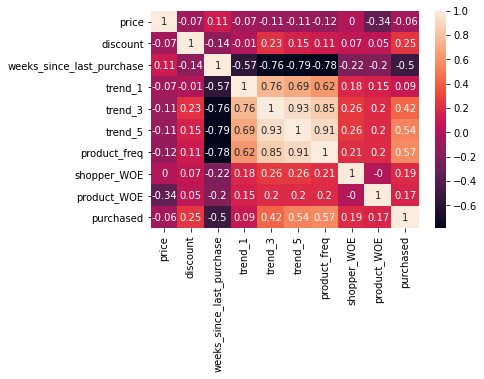

In [19]:
import seaborn as sns
sns.heatmap(X_train.join(y_train).corr().round(2), annot=True)

In [28]:
def _fit_lgbm(self, X_train, y_train, **kwargs):
    import lightgbm
    model = lightgbm.LGBMClassifier()
    model.fit(X_train, y_train)
    return model

def fit(self, model_type, X_train, y_train, **kwargs):
    return eval(f"self._fit_{model_type}(X_train, y_train, **kwargs)")


setattr(Purchase_Probabilities, '_fit_lgbm', _fit_lgbm)
del _fit_lgbm

setattr(Purchase_Probabilities, 'fit', fit)
del fit

In [33]:
model = purchase.fit('lgbm', X_train, y_train)

In [40]:
def predict(self, model, X):
    import lightgbm
    if type(model) == lightgbm.sklearn.LGBMClassifier:
        y_hat = model.predict_proba(X)[:, 1]
    return y_hat

setattr(Purchase_Probabilities, 'predict', predict)
del predict

In [42]:
y_hat = purchase.predict(model, X_test)

In [44]:
def score(self, y_true, y_hat, metric='log_loss'):
    if metric == 'log_loss':
        import sklearn
        metric = sklearn.metrics.log_loss
    
    return metric(y_true, y_hat)

setattr(Purchase_Probabilities, 'score', score)
del score

In [45]:
purchase.score(y_test, y_hat)

0.11912694632140541

In [48]:
purchase.dump(DATA_PATH, which='data')